# Data Scientist Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


This notebook walks you through one of the most popular Udacity projects across machine learning and artificial intellegence nanodegree programs.  The goal is to classify images of dogs according to their breed.  

If you are looking for a more guided capstone project related to deep learning and convolutional neural networks, this might be just it.  Notice that even if you follow the notebook to creating your classifier, you must still create a blog post or deploy an application to fulfill the requirements of the capstone project.

Also notice, you may be able to use only parts of this notebook (for example certain coding portions or the data) without completing all parts and still meet all requirements of the capstone project.

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
# import modules
from sklearn.datasets import load_files       
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint  
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from extract_bottleneck_features import *
from tqdm import tqdm
import numpy as np
from glob import glob
import cv2
import random
from PIL import ImageFile   
from time import time

# set options and magic functions
%matplotlib inline
random.seed(8675309)
ImageFile.LOAD_TRUNCATED_IMAGES = True  

Using TensorFlow backend.


In [86]:
## clear current keras models
#import keras
#keras.backend.clear_session()

In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [5]:
# save dog names / categories into file for the web application
with open('dog_names.txt', 'w') as f:
    for item in dog_names:
        f.write("%s\n" % item)

In [88]:
def show_random_image(image_set):
    '''
    Function to show a random image of an image set
    IN:  image_set(array of strings representing paths to images)
    OUT: plot of a random image
    '''
    rnd_idx = random.randint(0,len(image_set))
    img = plt.imread(image_set[rnd_idx])
    plt.imshow(img)
    plt.axis('off');  

def show_random_dog_image(image_set):
    '''
    Function to show a random image of an dog image set
    IN:  image_set(array of strings representing paths to images)
    OUT: plot of a random image
    '''
    rnd_idx = random.randint(0,len(image_set))
    img = plt.imread(image_set[rnd_idx])
    dog_name = dog_names[np.argmax(train_targets[rnd_idx])]
    print("This is a",dog_name.split('.')[1])
    plt.imshow(img)
    plt.axis('off');    

This is a Chow_chow


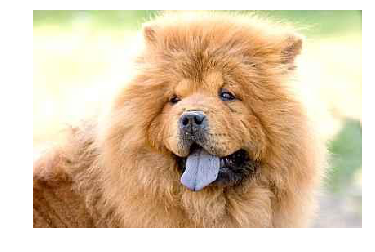

In [89]:
show_random_dog_image(train_files)

### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [10]:
# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


In [11]:
# show an example of an image containing a human
show_random_image(human_files)

NameError: name 'show_random_image' is not defined

---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](https://docs.opencv.org/trunk/db/d28/tutorial_cascade_classifier.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


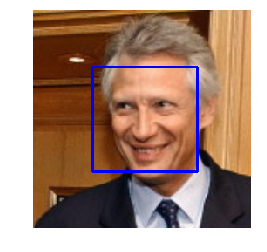

In [12]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[random.randint(0,len(human_files))])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.axis('off')
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [13]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

With the CV-based face detector function, I was able to detect 98% of the faces in the `human_faces` imageset. I.e., I have an error rate of 2% of the images with a human in it, where the function could not detect any face. However, the detector found 11 faces in 100 dog images, which gives an error rate of 11%.

In [14]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
face_count_human_files = len([i for i in human_files_short if face_detector(i) == True])
face_count_dog_files = len([i for i in dog_files_short if face_detector(i) == True])
print("Percentage of detected human faces in human_files: {}%".format(face_count_human_files))
print("Percentage of detected human faces in dog_files: {}%".format(face_count_dog_files))


Percentage of detected human faces in human_files: 100%
Percentage of detected human faces in dog_files: 11%


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [95]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.
# returns "True" if face is detected in image stored at img_path


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [3]:
# define ResNet50 model
ResNet50_model_0 = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


In [4]:
ResNet50_model_0.save('./saved_models/ResNet50_dog_predict.h5')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [15]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [16]:
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model_0.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [17]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

With the pre-trained CNN dog detector function, I was able to detect 100% of the dogs in the `dog_files` imageset. However, the detector found 0 dog in 100 images of the `human_faces` imageset, which gives an error rate of 0%. Thus, the dog detector shows better results than the face detector.

In [18]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dog_count_human_files = len([i for i in human_files_short if dog_detector(i) == True])
dog_count_dog_files = len([i for i in dog_files_short if dog_detector(i) == True])
print("Percentage of detected dogs in human_files: {}%".format(dog_count_human_files))
print("Percentage of detected dogs in dog_files: {}%".format(dog_count_dog_files))


Percentage of detected dogs in human_files: 0%
Percentage of detected dogs in dog_files: 100%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [19]:
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 125.93it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

- The images are preprocessed to have a size of an input shape of 223 by 223 matrix with three color channels (223,223,3).

- The first layer is a two-dimensional convolution layer, which creates a convolution kernel with a specific number of output filters (16 as shwon in the output shape in the image above). The purpose of this layer is to identify low-level features such as edges in the image. In this layer, the kernel has a size of a 2 to obtain the same amount of parameters as in the architecture shown above. To preserve the spatial dimensions of the image, we choose `same` as padding at the image boundaries. The activation function is a Rectified Linear Unit or `relu` in short. 

- The two-dimensional MaxPooling layer is used to reduce the spatial dimensions of the output volume. The pool size parameter contains the downscale factor for each dimension. In the architecture shown in the image above, we are instructed to downscale from (223,223,16) to (111,111,16). Thus, we choose a pool_size of (2,2).

- The following convolution layer is quite like the first with the difference of the number of output filters, which should be 32 in this layer.

- Again, we reduce the image size by the factor of two for both height and width by using a MaxPooling layer.

- The third convolution layer has an output shape of (54,54,64). Thus, we have to choose 64 for the number of filters.

- The third MaxPooling layer reduces the image size by the same factor to obtain an output shape of (27,27,64).

- The seventh layer in total is a two-dimensional GlobalAveragePooling layer, which calculates the global average of the image and reduces the size to one times the number of output filters (64)

- The final Dense layer contains 133 nodes and a softmax function as activation to obtain a probability for the 133 classes (dog breeds)

In [20]:
# Build model architecture
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, kernel_size=2, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=2, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [21]:
# compile model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [22]:
### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 22s 3ms/step - loss: 4.8831 - acc: 0.0106 - val_loss: 4.8690 - val_acc: 0.0132
Epoch 2/5
6680/6680 [==============================] - 22s 3ms/step - loss: 4.8619 - acc: 0.0106 - val_loss: 4.8535 - val_acc: 0.0168
Epoch 3/5
6680/6680 [==============================] - 22s 3ms/step - loss: 4.8260 - acc: 0.0147 - val_loss: 4.8203 - val_acc: 0.0192
Epoch 4/5
6680/6680 [==============================] - 22s 3ms/step - loss: 4.7935 - acc: 0.0190 - val_loss: 4.8014 - val_acc: 0.0251
Epoch 5/5
6680/6680 [==============================] - 22s 3ms/step - loss: 4.7623 - acc: 0.0238 - val_loss: 4.7817 - val_acc: 0.0180


### Load the Model with the Best Validation Loss

In [23]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [24]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 2.0335%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [107]:
# download the bottleneck features of VGG-16
! wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz
! mv DogVGG16Data.npz ./bottleneck_features/

--2019-06-30 17:56:42--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.16
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 850230376 (811M) [application/x-www-form-urlencoded]
Saving to: ‘DogVGG16Data.npz’

DogVGG16Data.npz    100%[===================>] 810.84M  75.4MB/s    in 11s     

2019-06-30 17:56:53 (73.8 MB/s) - ‘DogVGG16Data.npz’ saved [850230376/850230376]



In [108]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [109]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [110]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [111]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 20s 3ms/step - loss: 12.8923 - acc: 0.1063 - val_loss: 11.6326 - val_acc: 0.1784
Epoch 2/20
6680/6680 [==============================] - 5s 678us/step - loss: 11.0221 - acc: 0.2406 - val_loss: 10.9896 - val_acc: 0.2335
Epoch 3/20
6680/6680 [==============================] - 5s 682us/step - loss: 10.3823 - acc: 0.2961 - val_loss: 10.5185 - val_acc: 0.2599
Epoch 4/20
6680/6680 [==============================] - 4s 673us/step - loss: 10.0375 - acc: 0.3329 - val_loss: 10.2870 - val_acc: 0.2922
Epoch 5/20
6680/6680 [==============================] - 5s 691us/step - loss: 9.8307 - acc: 0.3548 - val_loss: 10.2015 - val_acc: 0.3018
Epoch 6/20
6680/6680 [==============================] - 5s 676us/step - loss: 9.6401 - acc: 0.3743 - val_loss: 10.0839 - val_acc: 0.3150
Epoch 7/20
6680/6680 [==============================] - 5s 693us/step - loss: 9.5328 - acc: 0.3868 - val_loss: 10.0379 - val_acc

### Load the Model with the Best Validation Loss

In [112]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [113]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 42.9426%


### Predict Dog Breed with the Model

In [114]:
def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [115]:
dog_names_pred = VGG16_predict_breed('./images/American_water_spaniel_00648.jpg')
dog_names_pred

'ages/train/009.American_water_spaniel'

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [3]:
# download the bottleneck features of VGG-19
! wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz
! mv DogVGG19Data.npz ./bottleneck_features/

--2019-06-28 16:41:09--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.56
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 850230376 (811M) [application/x-www-form-urlencoded]
Saving to: ‘DogVGG19Data.npz’

DogVGG19Data.npz    100%[===================>] 810.84M  69.2MB/s    in 12s     

2019-06-28 16:41:21 (67.2 MB/s) - ‘DogVGG19Data.npz’ saved [850230376/850230376]



In [20]:
# create training validation and testing bottleneck features
bottleneck_features_VGG19 = np.load('bottleneck_features/DogVGG19Data.npz')
train_VGG19 = bottleneck_features_VGG19['train']
valid_VGG19 = bottleneck_features_VGG19['valid']
test_VGG19 = bottleneck_features_VGG19['test']

In [92]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

# download the bottleneck features of ResNet-50
! wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz
! mv DogResnet50Data.npz ./bottleneck_features/

--2019-06-28 17:14:41--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.96
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80602216 (77M) [application/x-www-form-urlencoded]
Saving to: ‘DogResnet50Data.npz’

DogResnet50Data.npz 100%[===================>]  76.87M  61.8MB/s    in 1.2s    

2019-06-28 17:14:43 (61.8 MB/s) - ‘DogResnet50Data.npz’ saved [80602216/80602216]



In [25]:
# create training validation and testing bottleneck features
bottleneck_features_Resnet50 = np.load('bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = bottleneck_features_Resnet50['train']
valid_Resnet50 = bottleneck_features_Resnet50['valid']
test_Resnet50 = bottleneck_features_Resnet50['test']

In [ ]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

# download the bottleneck features of Inception
! wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz
! mv DogInceptionV3Data.npz ./bottleneck_features/

In [ ]:
# create training validation and testing bottleneck features
bottleneck_features_InceptionV3 = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features_InceptionV3['train']
valid_InceptionV3 = bottleneck_features_InceptionV3['valid']
test_InceptionV3 = bottleneck_features_InceptionV3['test']

In [ ]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

# download the bottleneck features of Xception
! wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz
! mv DogXceptionData.npz ./bottleneck_features/

In [ ]:
# create training validation and testing bottleneck features
bottleneck_features_Xception = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features_Xception['train']
valid_Xception = bottleneck_features_Xception['valid']
test_Xception = bottleneck_features_Xception['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
To build a model architecture by using transfer learning, I started as in [Step 4](#step4). So I chose a pretrained convolutional neural network and loaded the bottleneck features for it. Since I had no idea which one of the pretrained CNNs will fit best on the dog breed dataset, I tested all of them. Therefor, I loaded all bottleneck features into the workspace to evaluate their performance. 

The bottleneck features are very different in size:
* VGG19: 811 MB
* ResNet50: 77 MB
* InceptionV3: 1590 MB
* Xception: ~3100 MB

However, I was not able to load the Xception bottleneck features because the file was too big. Thus, I had to focus on the VGG19, ResNet50 and InceptionV3 networks.

To train the dog breed dataset, we have to adjust the architecture of the pretrained network to the output shape of the dataset as we have done in [Step 4](#step4). So, I added a GlobalAveragePooling2D layer as well as a fully-connected layer with 133 nodes for 133 dog breeds. This was defined as my standard architecture for the next step.

To find an efficient and appropriate model for the dataset, I trained and tested all three networks with different parameters and evaluated the training time and the accuracy on the testing dataset. Within the first step of my evaluation, I tested different optimizers for the models, namely the Stochastic Gradient Descent optimizer (`sgd`) and the RMSProp optimizer (`rmsprop`). I obtained following results:

| network     |     rmsprop     |       sgd       |
|-------------|:---------------:|:---------------:|
| VGG19       | 47.72% (34.8 s) | 58.01% (32.4 s) |
| ResNet50    | 80.26% (29.8 s) | 83.97% (27.9 s) |
| InceptionV3 | 78.83% (45.1 s) | 82.89% (40.4 s) |

We can see that although in all cases the SGD optimizer is able to create more accurate results in a shorter training time. Thus, I will use this optimizer for the next evaluation step.

After finding an optimizer, I wanted to make the CNN a little bit more complex by adding a further dense layer before the final dense layer (the one with 133 nodes) as well as a dropout layer to avoid overfitting of the model. I.e., the structure of the sequential model looks like this:

![My CNN](images/my_cnn.png)

To tune the models, I evaluated the accuracy and training time by using three different number of nodes for the added dense layer (256, 512 and 1024 nodes) and three different dropout rates (dr) for the dropout layer (0.1, 0.2 and 0.3). The results were:

| (dr, nodes) |    VGG19        |    ResNet50     |   InceptionV3   |
|-------------|:---------------:|:---------------:|:---------------:|
| (0.1, 256)  | 75.60% (35.5 s) | 83.61% (33.4 s) | 82.53% (47.6 s) |
| (0.2, 256)  | 76.79% (35.8 s) | 83.97% (33.2 s) | 82.66% (47.4 s) |
| (0.3, 256)  | 77.27% (35.9 s) | 83.73% (33.3 s) | 82.54% (47.7 s) |
| (0.1, 512)  | 76.91% (36.3 s) | 82.78% (36.3 s) | 83.13% (50.2 s) |
| (0.2, 512)  | 77.15% (36.8 s) | 84.20% (36.3 s) | 81.22% (50.5 s) |
| (0.3, 512)  | 77.63% (37.5 s) | 83.85% (36.5 s) | 83.01% (50.3 s) |
| (0.1, 1024) | 78.11% (38.7 s) | 84.40% (42.5 s) | 83.37% (56.2 s) |
| (0.2, 1024) | 80.50% (38.9 s) | 84.09% (41.7 s) | 83.13% (55.9 s) |
| (0.3, 1024) | 79.78% (38.6 s) | **85.29%** (44.8 s) | 83.25% (56.0 s) |

As shown in the table above, the ResNet50 network shows the best performance. This model has the highest accuracy for each combination of parameters and has a short training time, especially for a small number of nodes in the dense layer. However, the training time increases significantly by adding more nodes to that layer. The accuracy of the InceptionV3 network is only slightly worse but the network seems very complex, resulting in high training times. The least accurate model is obtained by using the pretrained VGG19 CNN, however, it seems quite efficient when we use more nodes in the dense layer.

Since I wanted to priorize the accuracy of the model, I used the ResNet50 CNN with a dense layer with 1024 nodes and a dropout rate of 0.3, although the same model with a dropout rate of 0.1 nearly achieved the same accuracy. I also tried samples of higher dropout rates but did not achieve an accuracy higher than 85.29%.

In [26]:
# define parameters to compare different types of models
dropout_rate = 0.3
dense_layer_nodes = 1024

In [21]:
### TODO: Define your architecture. Select the model you like by executing the respective cell

# Define Architecture for VGG19_model
VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
VGG19_model.add(Dense(dense_layer_nodes, activation='relu'))
VGG19_model.add(Dropout(dropout_rate))
VGG19_model.add(Dense(133, activation='softmax'))
VGG19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               136325    
Total params: 661,637
Trainable params: 661,637
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Define Architecture for ResNet50_model
ResNet50_model = Sequential()
ResNet50_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
ResNet50_model.add(Dense(dense_layer_nodes, activation='relu'))
ResNet50_model.add(Dropout(dropout_rate))
ResNet50_model.add(Dense(133, activation='softmax'))
ResNet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               136325    
Total params: 2,234,501
Trainable params: 2,234,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### TODO: Define your architecture.
# Define Architecture for InceptionV3_model
InceptionV3_model = Sequential()
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dense(dense_layer_nodes, activation='relu'))
InceptionV3_model.add(Dropout(dropout_rate))
InceptionV3_model.add(Dense(133, activation='softmax'))
InceptionV3_model.summary()

### (IMPLEMENTATION) Compile the Model

In [23]:
### TODO: Compile the model. Compile the model by executing the respective cell.

# compile the VGG19_model
VGG19_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [28]:
# compile the ResNet50_model
ResNet50_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
# compile the InceptionV3_model
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [24]:
### TODO: Train the model. Train the model by executing the respective cell.

# train VGG19_model
VGG19_filepath = 'saved_models/weights.best.VGG19_{}_{}.hdf5'.format(dropout_rate,dense_layer_nodes)

checkpointer = ModelCheckpoint(filepath=VGG19_filepath, 
                               verbose=1, save_best_only=True)
start = time()
VGG19_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)
print("Training Time for VGG19_model:", time() - start)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 328us/step - loss: 3.1254 - acc: 0.4548 - val_loss: 1.1986 - val_acc: 0.6707
Epoch 2/20
6680/6680 [==============================] - 2s 314us/step - loss: 0.8529 - acc: 0.7581 - val_loss: 0.9934 - val_acc: 0.6970
Epoch 3/20
6680/6680 [==============================] - 2s 314us/step - loss: 0.5213 - acc: 0.8373 - val_loss: 0.9747 - val_acc: 0.7341
Epoch 4/20
6680/6680 [==============================] - 2s 299us/step - loss: 0.3690 - acc: 0.8846 - val_loss: 0.8470 - val_acc: 0.7461
Epoch 5/20
6680/6680 [==============================] - 2s 307us/step - loss: 0.2456 - acc: 0.9247 - val_loss: 0.8222 - val_acc: 0.7593
Epoch 6/20
6680/6680 [==============================] - 2s 313us/step - loss: 0.1860 - acc: 0.9463 - val_loss: 0.7963 - val_acc: 0.7737
Epoch 7/20
6680/6680 [==============================] - 2s 301us/step - loss: 0.1297 - acc: 0.9656 - val_loss: 0.8505 - val_acc: 0.7665
E

In [29]:
# train ResNet50_model
ResNet50_filepath = 'saved_models/weights.best.ResNet50_{}_{}.hdf5'.format(dropout_rate,dense_layer_nodes)

checkpointer = ModelCheckpoint(filepath=ResNet50_filepath, 
                               verbose=1, save_best_only=True)

start = time()
ResNet50_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)
print("Training Time for ResNet50_model:", time() - start)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 378us/step - loss: 3.0160 - acc: 0.3518 - val_loss: 1.4633 - val_acc: 0.6743
Epoch 2/20
6680/6680 [==============================] - 2s 327us/step - loss: 1.1973 - acc: 0.6883 - val_loss: 0.9039 - val_acc: 0.7605
Epoch 3/20
6680/6680 [==============================] - 2s 331us/step - loss: 0.7721 - acc: 0.7955 - val_loss: 0.7552 - val_acc: 0.7928
Epoch 4/20
6680/6680 [==============================] - 2s 330us/step - loss: 0.5921 - acc: 0.8377 - val_loss: 0.6648 - val_acc: 0.8000
Epoch 5/20
6680/6680 [==============================] - 2s 327us/step - loss: 0.4751 - acc: 0.8710 - val_loss: 0.6186 - val_acc: 0.8240
Epoch 6/20
6680/6680 [==============================] - 2s 325us/step - loss: 0.4031 - acc: 0.8898 - val_loss: 0.5757 - val_acc: 0.8299
Epoch 7/20
6680/6680 [==============================] - 2s 324us/step - loss: 0.3461 - acc: 0.9082 - val_loss: 0.5859 - val_acc: 0.8144
E

In [ ]:
# train InceptionV3_model
#InceptionV3_filepath = 'saved_models/weights.best.InceptionV3.hdf5'
InceptionV3_filepath = 'saved_models/weights.best.InceptionV3_{}_{}.hdf5'.format(dropout_rate,dense_layer_nodes)

checkpointer = ModelCheckpoint(filepath=InceptionV3_filepath, 
                               verbose=1, save_best_only=True)
start = time()
InceptionV3_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)
print("Training Time for InceptionV3_model:", time() - start)

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [30]:
### TODO: Load the model weights with the best validation loss. Select the model by uncommenting the respective command

#VGG19_model.load_weights(VGG19_filepath)
ResNet50_model.load_weights(ResNet50_filepath)
#InceptionV3_model.load_weights(InceptionV3_filepath)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [26]:
### TODO: Calculate classification accuracy on the test dataset. Evaluate the model by executing the respective cell.

# get index of predicted dog breed for each image in test set
VGG19_predictions = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]

# report test accuracy
test_accuracy_VGG19 = 100*np.sum(np.array(VGG19_predictions)==np.argmax(test_targets, axis=1))/len(VGG19_predictions)
print('Test accuracy for VGG19_model (Dropout:%.2f, Nodes: %d): %.4f%%' %(dropout_rate, dense_layer_nodes, test_accuracy_VGG19))

Test accuracy for VGG19_model (Dropout:0.20, Nodes: 1024): 77.5120%


In [31]:
# get index of predicted dog breed for each image in test set
ResNet50_predictions = [np.argmax(ResNet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy_ResNet50 = 100*np.sum(np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
print('Test accuracy for ResNet50_model (Dropout:%.2f, Nodes: %d): %.4f%%' %(dropout_rate, dense_layer_nodes, test_accuracy_ResNet50))

Test accuracy for ResNet50_model (Dropout:0.30, Nodes: 1024): 85.2871%


In [ ]:
# get index of predicted dog breed for each image in test set
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# report test accuracy
test_accuracy_InceptionV3 = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
#print('Test accuracy for InceptionV3_model: %.4f%%' %(test_accuracy_InceptionV3))
print('Test accuracy for InceptionV3_model (Dropout:%.2f, Nodes: %d): %.4f%%' %(dropout_rate, dense_layer_nodes, test_accuracy_InceptionV3))

In [51]:
## clear current keras models if needed 
#import keras
#keras.backend.clear_session()

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [32]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def VGG19_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG19(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG19_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

def ResNet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = ResNet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]


def InceptionV3_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = InceptionV3_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]


Actual:  Boykin_spaniel
Prediction:  Boykin_spaniel


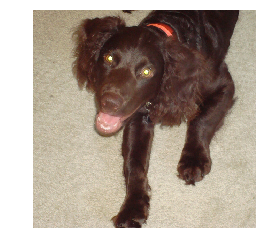

In [35]:
## Make a prediction of a random image of the test files dataset 
## and show the actual and predicted dog breed as well as an image of the dog.
rnd_idx = random.randint(0,len(test_files))
img = plt.imread(test_files[rnd_idx])
dog_name = dog_names[np.argmax(test_targets[rnd_idx])]
# use the ResNet50_model to make predictions
dog_names_pred = ResNet50_predict_breed(test_files[rnd_idx])
print("Actual: ",dog_name.split('.')[1])
print("Prediction: ",dog_names_pred.split('.')[1])
plt.imshow(img)
plt.axis('off'); 

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

In [36]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def predict_dog_breed(img_path):
    dog_names_pred = ResNet50_predict_breed(img_path)
    if dog_detector(img_path):
        print("This photo looks like a", dog_names_pred.split('.')[1],"!")
    elif face_detector(img_path):
        print("This human mostly resembles a", dog_names_pred.split('.')[1],"!")
    else:
        print("ERROR: Neither a dog nor a human was detected in the image!")
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis('off');

This human mostly resembles a Silky_terrier !


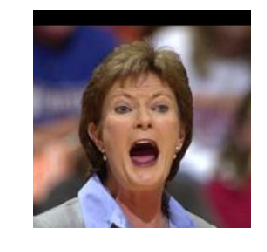

In [37]:
# Test the algorithm
# choose an imageset to test the algorithms for dogs and humans
imageset = human_files
# pick a random image out of the imageset and predict the dog breed
rnd_idx = random.randint(0,len(imageset))
img_path = imageset[rnd_idx]
predict_dog_breed(img_path)

This photo looks like a Dalmatian !


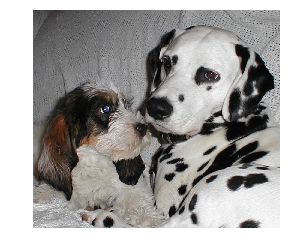

In [38]:
# Test the algorithm
# choose an imageset to test the algorithms for dogs and humans
imageset = dog_files_short
# pick a random image out of the imageset and predict the dog breed
rnd_idx = random.randint(0,len(imageset))
img_path = imageset[rnd_idx]
predict_dog_breed(img_path)

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The output of the test of the implemented algorithm was as expected. The created model achieved an accuracy of 84.69% in correctly identifying dog breeds by showing a picture of a dog. In the test below, where I used images of the `test_images` folder, I wanted to know how good the algorithm is in distinguishing dogs and human beings from other animals in a photo. Here, all (real) dogs were found and the dog breed was correctly classified. Both human beings (male and female) were also found in the right way. Furthermore the algorithm named the dog breed the human ressembles. However, the three images without any real dog or human were only partly correct. The face detector and dog detector correctly discard the pig and the drawing of a dog, but the face detector failed in classifying the cat as a human being. Thus, a dog breed was assigned which resembles most. In this case, the Maltese was picked by the algorithm, which is at least a good choice because it really resembles this picture of a cat.

Improvements for my algorithm:
1. The training set of dog images might be a little bit to small. Thus, the model might perform in a better way, if we could provide a larger training set.
2. To find an appropriate model, I only tuned some parameters like optimizer, dropout rate and nodes of a dense layer. For the other options or for the optimizer itself, I used the default parameters. To achieve better models, it might be promising to fine-tune the hyperparameter by using GridSearch.
3. The preprocessing of the images are very constrained. I only took the images as they were and only adjusted the size. Here, better results might be achieved by using augmentations as described [here](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/). Techniques to do so are presented in this [Github Repository](https://github.com/aleju/imgaug).

In [39]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

test_images = glob("./test_images/*.jpg")
test_images

['./test_images/trump.jpg',
 './test_images/doberman.jpg',
 './test_images/dog-1404109-639x852.jpg',
 './test_images/american-staffordshire-terrier-3616318_960_720.jpg',
 './test_images/english_bulldog.jpg',
 './test_images/pot_belly_pig.jpg',
 './test_images/pluto_disney.jpg',
 './test_images/merkel.jpg',
 './test_images/collie.jpg',
 './test_images/cat.jpg']

This human mostly resembles a Nova_scotia_duck_tolling_retriever !


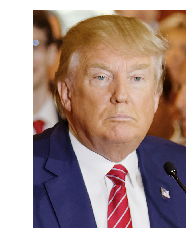

In [40]:
predict_dog_breed(test_images[0])

This photo looks like a Doberman_pinscher !


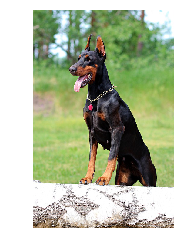

In [41]:
predict_dog_breed(test_images[1])

This photo looks like a Irish_setter !


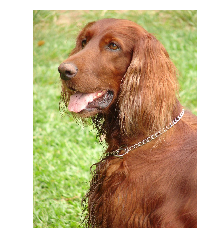

In [42]:
predict_dog_breed(test_images[2])

This photo looks like a American_staffordshire_terrier !


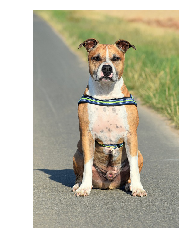

In [43]:
predict_dog_breed(test_images[3])

This photo looks like a Bulldog !


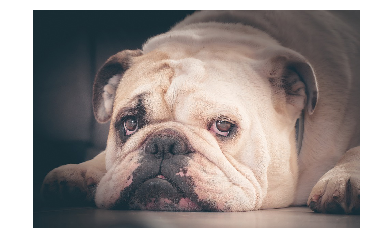

In [44]:
predict_dog_breed(test_images[4])

ERROR: Neither a dog nor a human was detected in the image!


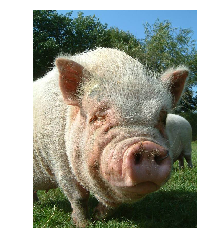

In [45]:
predict_dog_breed(test_images[5])

ERROR: Neither a dog nor a human was detected in the image!


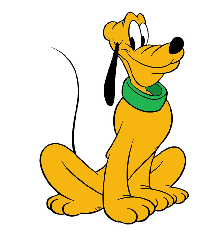

In [46]:
predict_dog_breed(test_images[6])

This human mostly resembles a Nova_scotia_duck_tolling_retriever !


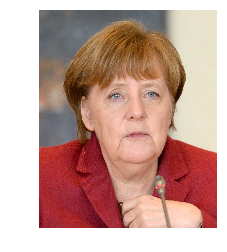

In [47]:
predict_dog_breed(test_images[7])

This photo looks like a Collie !


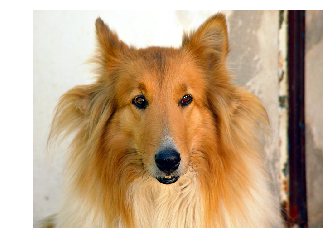

In [48]:
predict_dog_breed(test_images[8])

This human mostly resembles a Maltese !


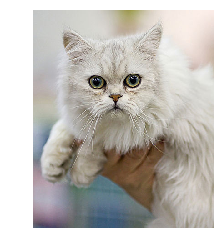

In [49]:
predict_dog_breed(test_images[9])

In [51]:
# save the model to apply it within the web app
ResNet50_model.save("./saved_models/ResNet50_model.h5")